In [451]:
import os

import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np
import xrspatial
from shapely import Point, LineString, Polygon
import matplotlib.pyplot as plt

from valleys.utils import setup_wbt
from valleys.cross_section import rezero_alphas, preprocess_channel, vectorize_stream_from_hillslope_raster, rioxarray_sample_points, get_cross_section_points

In [526]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [592]:
wbt = setup_wbt(whitebox_dir=os.path.expanduser("~/opt/WBT/"), working_dir=os.path.abspath("../data/wb_outputs/"))

dem_file = os.path.abspath("../data/huc12s/180400060403///subbasins/22.0_dem.tif")
hillslopes_file = os.path.abspath("../data/huc12s/180400060403///subbasins/22.0_hillslopes.tif")

hs = rioxarray.open_rasterio(hillslopes_file).squeeze()
dem = rioxarray.open_rasterio(dem_file).squeeze()

In [593]:
# get slope and curvature of soothed dem
wbt.gaussian_filter(dem_file, "smoothed.tif", 0.75)
wbt.slope("smoothed.tif", "slope.tif")
wbt.profile_curvature("smoothed.tif", "profile_curvature.tif")

slope_file = os.path.join(wbt.work_dir, "slope.tif")
curvature_file = os.path.join(wbt.work_dir, "profile_curvature.tif")

slope = rioxarray.open_rasterio(slope_file).squeeze()
slope = slope.where(slope != -32768)
curvature = rioxarray.open_rasterio(curvature_file).squeeze()
curvature = curvature.where(curvature != -32768)

In [594]:
stream = vectorize_stream_from_hillslope_raster(wbt, hs)
centerline = preprocess_channel(stream, method='simplify', threshold=50)

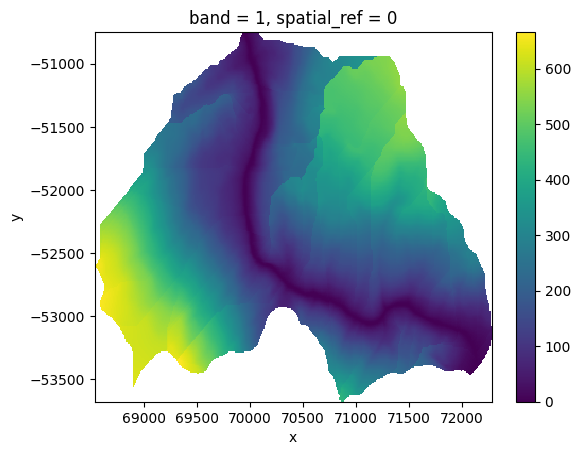

In [595]:
df = gpd.GeoDataFrame(geometry=[stream], crs=3310)
df.to_file(os.path.join(wbt.work_dir, 'streams.shp'))
wbt.rasterize_streams('streams.shp', dem_file, 'streams.tif')
wbt.fill_depressions(dem_file, 'filled.tif')
wbt.elevation_above_stream('filled.tif', 'streams.tif', 'hand.tif')
hand = rioxarray.open_rasterio(os.path.join(wbt.work_dir, "hand.tif")).squeeze()
hand = hand.where( hand != -32768)
hand.plot()

In [618]:
points = get_cross_section_points(centerline, xs_spacing=10, xs_width=200, xs_point_spacing=10)
points.head()

,alpha,point,cross_section_id
0,-200,POINT (69762.005 -50824.218),0
1,-190,POINT (69771.544 -50821.215),0
2,-180,POINT (69781.082 -50818.212),0
3,-170,POINT (69790.621 -50815.209),0
4,-160,POINT (69800.159 -50812.206),0


In [619]:
points['elevation'] = rioxarray_sample_points(hand, points)
points['slope'] = rioxarray_sample_points(slope, points)
points['curvature'] = rioxarray_sample_points(curvature, points)
points['hillslope_id'] = rioxarray_sample_points(hs, points)
points['point_id'] = range(len(points))

In [620]:
points2 = rezero_alphas(points)

In [621]:
def get_break_point(half_profile_df):
    df = half_profile_df.copy()
    df['alpha'] = df['alpha'].apply(abs)
    df = df.sort_values(by='alpha', ascending=True)
    
    peak_inds = list(signal.find_peaks(-df['curvature'], height=0.01))[0]
    
    for i,ind in enumerate(peak_inds):
        if i < len(peak_inds):
            slope = (df['elevation'].iloc[(ind + 1)] - df['elevation'].iloc[ind]) / ( df['alpha'].iloc[(ind+1)] - df['alpha'].iloc[ind])
        else:
            slope = (df['elevation'].iloc[-1] - df['elevation'].iloc[ind]) / d(f['alpha'].iloc[-1] - df['alpha'].iloc[ind])
        if slope > .25:
            return df['point_id'].iloc[ind]
    return np.nan
        

In [622]:
bps = []
for id in points2['cross_section_id'].unique():
    bp_1 = get_break_point(points2.loc[(points2['cross_section_id'] == id) & (points2['alpha'] >= 0)])
    bp_2 = get_break_point(points2.loc[(points2['cross_section_id'] == id) & (points2['alpha'] <= 0)])
    if not np.isnan(bp_1):
        bps.append(bp_1)
    if not np.isnan(bp_2):
        bps.append(bp_2)



In [623]:
bp_df = points2.iloc[bps]
bp_df

,alpha,point,cross_section_id,elevation,slope,curvature,hillslope_id,point_id
20,-10,POINT (69955.778 -50773.699),1,1.931641,15.978318,-0.021010,178.0,61
22,10,POINT (69992.872 -50824.924),7,2.412176,21.436285,-0.023176,177.0,309
20,-10,POINT (69973.795 -50830.930),7,4.088351,32.631626,-0.019381,178.0,307
22,10,POINT (70004.884 -50863.078),11,3.039551,22.196253,-0.022414,177.0,473
20,-10,POINT (69985.807 -50869.084),11,2.560303,26.350071,-0.025824,178.0,471
...,...,...,...,...,...,...,...,...
22,-10,POINT (72036.837 -53153.519),404,1.021118,10.737947,-0.017595,178.0,16586
21,-10,POINT (72043.300 -53174.925),406,3.519531,17.364330,-0.012825,178.0,16667
19,20,POINT (72063.898 -53196.736),409,2.008545,13.161114,-0.011965,178.0,16788
19,10,POINT (72070.765 -53204.006),410,1.349731,11.088678,-0.011551,178.0,16829


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

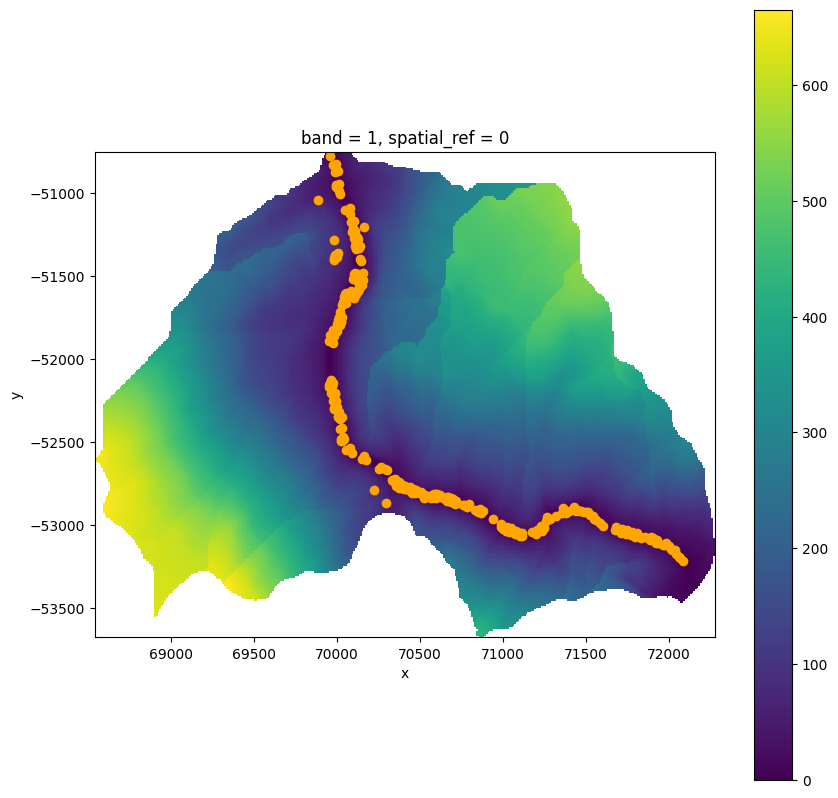

In [624]:
fig, ax = plt.subplots(figsize=(10,10))
hand.plot(ax=ax)
bp_df.plot(ax=ax, color='orange')

<Axes: ylabel='Frequency'>

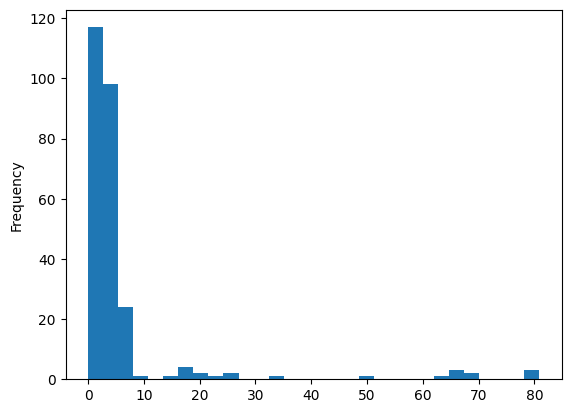

In [625]:
bp_df['elevation'].plot.hist(bins=30)

In [626]:
((bp_df['elevation']/ 3).round().astype(int) * 3).describe()

count    261.000000
mean       6.390805
std       13.249693
min        0.000000
25%        3.000000
50%        3.000000
75%        3.000000
max       81.000000
Name: elevation, dtype: float64

In [627]:
((bp_df['elevation']/ 3).round().astype(int) * 3).value_counts()

elevation
3     158
0      39
6      38
9       5
18      4
66      3
24      3
69      2
78      2
21      2
51      1
33      1
81      1
15      1
63      1
Name: count, dtype: int64